### Data Exploration Oluwaseyifunmi and Aminat
\- Open the Titanic passenger list (dataset) in Python.    
\- Show the first few passengers (rows) so everyone knows what’s inside.    
\- Check if any passenger info is missing (e.g., age, ticket price).    
\- Draw pictures (visualizations) to show how things like age or ticket class relate to survival.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
titanic = sns.load_dataset("titanic") # Load the Titanic dataset from Seaborn

In [3]:
print(titanic.head(10)) # Display the first ten rows


   survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0         0       3    male  22.0      1      0   7.2500        S   Third   
1         1       1  female  38.0      1      0  71.2833        C   First   
2         1       3  female  26.0      0      0   7.9250        S   Third   
3         1       1  female  35.0      1      0  53.1000        S   First   
4         0       3    male  35.0      0      0   8.0500        S   Third   
5         0       3    male   NaN      0      0   8.4583        Q   Third   
6         0       1    male  54.0      0      0  51.8625        S   First   
7         0       3    male   2.0      3      1  21.0750        S   Third   
8         1       3  female  27.0      0      2  11.1333        S   Third   
9         1       2  female  14.0      1      0  30.0708        C  Second   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes

In [4]:
# Basic information about the dataset
print("\nDataset Info:")
print(titanic.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [5]:
#Display the rows with missing values and amount of missing values
print(titanic.isnull().sum()) 

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


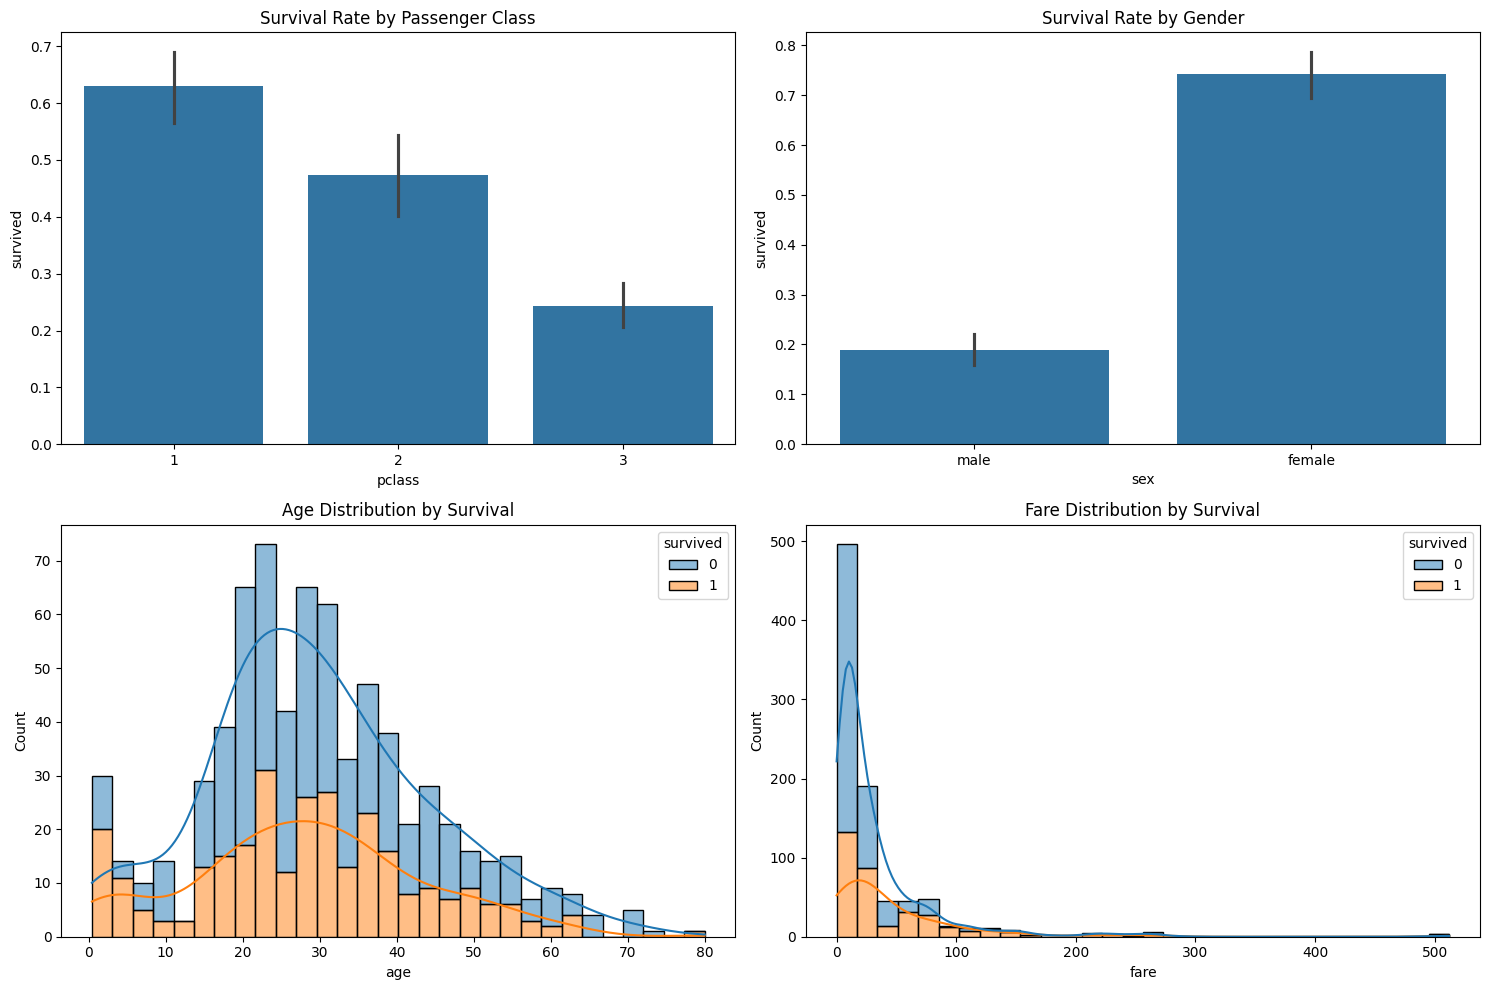

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(x='pclass', y='survived', data=titanic)
plt.title('Survival Rate by Passenger Class')

plt.subplot(2, 2, 2)
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival Rate by Gender')

plt.subplot(2, 2, 3)
sns.histplot(data=titanic, x='age', hue='survived', bins=30, kde=True, multiple='stack')
plt.title('Age Distribution by Survival')

plt.subplot(2, 2, 4)
sns.histplot(data=titanic, x='fare', hue='survived', bins=30, kde=True, multiple='stack')
plt.title('Fare Distribution by Survival')

plt.tight_layout()
plt.show()

### Data Cleaning by Fidelix        
\- Look for weird numbers (outliers) in ticket prices using boxplots and decide what to do.  

In [7]:
# Outlier detection + removal (chained assignment)
fare_q3 = titanic['fare'].quantile(0.75)
fare_iqr = fare_q3 - titanic['fare'].quantile(0.25)
fare_cap = fare_q3 + 1.5 * fare_iqr  # Tukey's method


In [8]:
titanic = titanic[titanic['fare'] <= fare_cap]

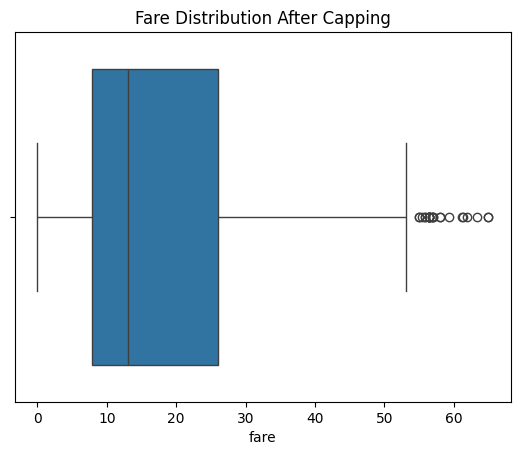

In [9]:
sns.boxplot(x=titanic['fare']).set(title='Fare Distribution After Capping');

### Feature Engineering by Kaothara and Yetunde
\- Create a Family Size feature by adding siblings (SibSp) and parents (Parch).    
\- Group ages into buckets like "kids," "teens," "adults," and "seniors."    
\- Group ticket prices into "cheap," "medium," and "expensive."  

In [10]:
### How many of them in the family
titanic['FamilySize'] = titanic['sibsp'] + titanic['parch']
# Define age bins and corresponding labels
bins = [0, 2, 12, 17, 64, 80]  # Adjust maximum age as needed
labels = ['Infant', 'Kid', 'Teen', 'Adult', 'Old_Age']

# Create a new column with age categories
titanic['AgeGroup'] = pd.cut(titanic['age'], bins=bins, labels=labels, right=True)

# Define fare bins and labels
## The fare group is created based on the Fare Statistics Summary
bins = [0, 13, 26, 66]  # 0–13: Cheap, >13–26: Medium, >26–65+: Expensive
labels = ['Cheap', 'Medium', 'Expensive']

# Create a new column
titanic['FareGroup'] = pd.cut(titanic['fare'], bins=bins, labels=labels, right=False)

### Data Transformation by Toluwalope, Fidelix and Ibraheem
\- Turn words (categories) like "male/female" or "embarkation port" into numbers (encoding).    
\- Scale numbers like age, fare, and family size so they’re fair for the model.  
\- Also fix any missing data

In [11]:
# Preprocessing pipeline
# Numeric features
numeric_features = ['age', 'fare', 'FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features
categorical_features = ['sex', 'embarked', 'AgeGroup', 'FareGroup']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [12]:
# Prepare features and target
X = titanic[['pclass', 'sex', 'age', 'fare', 'embarked', 'FamilySize', 'AgeGroup', 'FareGroup']]
y = titanic['survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model training by All the team members
\- Split passengers into a training group (70%) and a test group (30%).    
\- Teach the computer (train a model) to guess survival using Logistic Regression.    
\- Check if the computer is good at guessing (accuracy, confusion matrix).  

In [13]:
# Model training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
print("Model trained successfully!")

Model trained successfully!


In [14]:
# Model Evaluation
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78

Confusion Matrix:
[[128  23]
 [ 28  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       151
           1       0.70      0.66      0.68        82

    accuracy                           0.78       233
   macro avg       0.76      0.75      0.76       233
weighted avg       0.78      0.78      0.78       233



In [15]:
#  Make predictions 
new_data = pd.DataFrame({
    'pclass': [1, 3],
    'sex': ['female', 'male'],
    'age': [30, 25],
    'fare': [100, 20],
    'embarked': ['C', 'S'],
    'FamilySize': [1, 0],
    'AgeGroup': ['Adult', 'Adult'],
    'FareGroup': ['High', 'Low']
})

predictions = model.predict(new_data)
print("Predictions:", predictions)

Predictions: [1 0]


### Feature Importance Analysis by Ibraheem
- Most important positive survival factors 
- Most important negative survival factors

In [16]:
# Get feature names
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
cat_features = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

# Get coefficients
coefficients = model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})

# Sort by absolute value for importance
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Display top drivers
print("\nTop Positive Factors (Increased Survival):")
print(feature_importance[feature_importance['Coefficient'] > 0].head())

print("\nTop Negative Factors (Decreased Survival):")
print(feature_importance[feature_importance['Coefficient'] < 0].head())


Top Positive Factors (Increased Survival):
                Feature  Coefficient  Abs_Coefficient
3            sex_female     1.359814         1.359814
9       AgeGroup_Infant     0.789362         0.789362
10         AgeGroup_Kid     0.616057         0.616057
14  FareGroup_Expensive     0.535957         0.535957
1                  fare     0.359284         0.359284

Top Negative Factors (Decreased Survival):
            Feature  Coefficient  Abs_Coefficient
4          sex_male    -1.337508         1.337508
2        FamilySize    -0.921258         0.921258
8    AgeGroup_Adult    -0.668963         0.668963
12    AgeGroup_Teen    -0.635070         0.635070
13  FareGroup_Cheap    -0.599217         0.599217


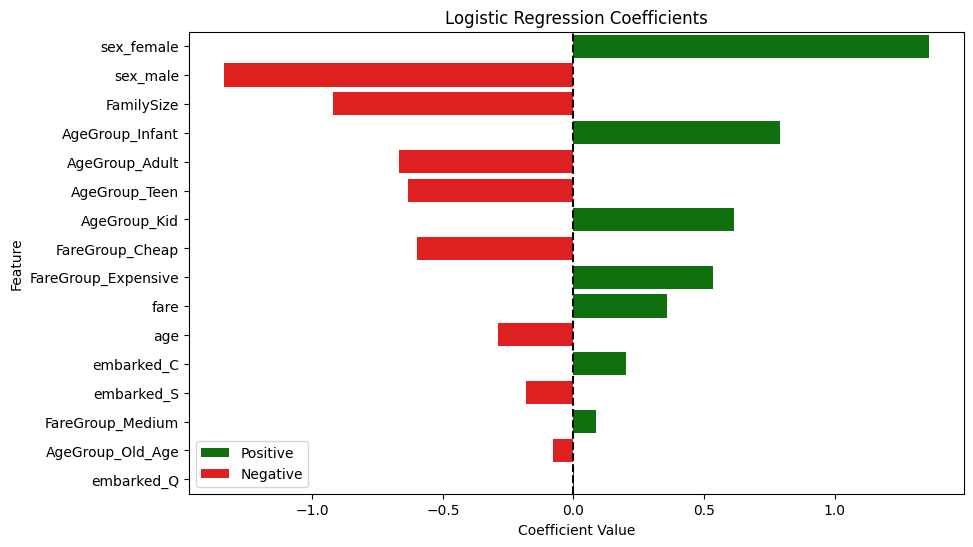

In [17]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=feature_importance,
    hue=np.where(feature_importance['Coefficient'] < 0, 'Negative', 'Positive'),
    palette={'Negative': 'red', 'Positive': 'green'},
    dodge=False 
)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

### Result
The model achieved 78% accuracy with the following key insights:
- Most important positive survival factors: 
- Female
- Infants
- Most important negative survival factors:
- Male
- Family Size